In [1]:
system(hostname)

['capuchino.fis.ucm.es']

In [2]:
#Basic pre-reqs:
import numpy as np
import torch
import time
from torch.autograd import Variable
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from celluloid import Camera
from copy import deepcopy as copy
%matplotlib inline

#!pip install celluloid

#!export CUDA=cu101 && pip install --upgrade torch-scatter==latest+${CUDA} torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.7.0.html
#!pip install --upgrade torch-geometric

# Mount your google drive in google colab
#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/ColabNotebooks/MLAM/GN_ABPs'

import models
import simulate

from sklearn.model_selection import train_test_split

import networkx as nx
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.utils import to_networkx

from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

from torch_geometric.data import Data, DataLoader
from models import get_edge_index

from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from tqdm import tqdm

import numpy as onp
onp.random.seed(0)

import pandas as pd

#small change


In [26]:
#############
# FUNCTIONS #
#############

# Loss function: This holds definition of our L1 and KL regularizations:

def new_loss(self, g, augment=True, square=False):
  if square:
      return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
  else:
      base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
      if test in ['_l1_', '_kl_']:
          s1 = g.x[self.edge_index[0]]
          s2 = g.x[self.edge_index[1]]
          if test == '_l1_':
              m12 = self.message(s1, s2)
              regularization = 1e-2
              #Want one loss value per row of g.y:
              normalized_l05 = torch.sum(torch.abs(m12))
              return base_loss, regularization * batch * normalized_l05 / n**2 * n
          elif test == '_kl_':
              regularization = 1
              #Want one loss value per row of g.y:
              tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
              raw_msg = self.msg_fnc(tmp)
              mu = raw_msg[:, 0::2]
              logvar = raw_msg[:, 1::2]
              full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
              return base_loss, regularization * batch * full_kl / n**2 * n
      return base_loss


# Function to record messages from model

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info


# Function to visualize network

def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        print("isTensor")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        print("isNotTensor")
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

    
# Functions to import LAMMPs data.

import glob, re

def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in _nsre.split(s)] 

def importFiles(filename_glob_pattern, dtype='float', delimiter=None, skip_header=0, usecols=None):
    sorted_file_list = sorted(glob.glob(filename_glob_pattern), key=natural_sort_key)
    data = []
    i=1;
    for file_path in sorted_file_list:
        data.append(
            np.genfromtxt(file_path, delimiter=delimiter, skip_header=skip_header, dtype=dtype, usecols=usecols))
        i+=1;
        if (i % 1000) == 0:
            clear_output(wait=True)
            print(i)
        
    print("Imported {} files.".format(len(data)))
        
    return data

def lammpsDump2numpy(frames):
    data = np.asarray(frames);
    data_attr = np.array([[[np.concatenate((row[2:6], np.array([0,1]))) for row in col] for col in data]]);    
    data_accel = np.array([[[row[6:8] for row in col] for col in data]]);  
    
    return data_attr, data_accel

In [4]:
# Initialization

init_lr = 1e-3

batch = 5 # int(64 * (4 / n)**2)

# With total_epochs=200, batch_per_epoch=2000 it takes ~13h.
total_epochs = 50



In [5]:
# Run one of the two following cells.

In [6]:
# # Generate simulation data with their JAX simulations (see simulate.py).

# import importlib
# importlib.reload(simulate)

# # Number of simulations to run (it's fast, don't worry):
# ns = 10

# # Potential (see below for options)
# sim = 'spring' #'r2'#

# # Number of nodes
# n = 10

# # Dimension
# dim = 2

# # Number of time steps (for some reason later it uses nt/2).
# nt = 10000

# # Time step

# dt = 0.01

# #Standard simulation sets:
# n_set = [4, 8]
# sim_sets = [
# {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
# {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'BD', 'dt': [1e-5], 'nt': [2001], 'n': n_set, 'dim': [2, 3]},
# ]

# #Select the hand-tuned dt value for a smooth simulation
# # (since scales are different in each potential):
# dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

# title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
# print('Running on', title)

# # ??? Why nt//2
# from simulate import SimulationDataset
# s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt) 

# # Update this to your own dataset, or regenerate:
# base_str = './'
# data_str = title
# s.simulate(ns)

# # data has [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
# data_attr = s.data
# data_accel = s.get_acceleration()

# print("Attr shape: [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]] ")
# print(data_attr.shape)
# print("Accl shape: [simulation ID, time, particle ID, [accelx, accely]] ")
# print(data_accel.shape)


In [27]:
# Use LAMMPs simulation data

import importlib
importlib.reload(simulate)

# Number of simulations to run (it's fast, don't worry):
ns = 1

# Potential (see below for options)
sim = 'BD'

# Number of nodes
n = 25

# Dimension
dim = 2

# Number of time steps
nt = 10000

# Time step

dt = 0.01

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'BD', 'dt': [1e-5], 'nt': [2000], 'n': n_set, 'dim': [2, 3]},
]

# Import LAMMPs data (passive system, Pe=1e-6).
fileNamePatt="../../lammps/data/20210802_small-system_passive-attractive/Tsim1.00e+07_dt1.00e-05_N2.50e+01_phi6.00e-01_Pe1.00e-06_Fp2.40e+01_KT1.00e-01_Dt1.50e+00/Frames/frame.*000"
frames = importFiles(fileNamePatt, delimiter=" ", skip_header=9, usecols=range(0,8))

# Transform LAMMPs data to PyTorch format:
# data_attr: [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
# data_acccel: [simulation ID, time, particle ID, [accelx, accely]]

# data = np.asarray(frames);
# data_attr = np.array([[[np.concatenate((row[2:6], np.array([idx,1]))) for row in col] for idx, col in enumerate(data)]]);
# data_accel = np.array([[[row[6:8] for row in col] for col in data]]);

# data_attr, data_accel = lammpsDump2numpy(frames)
data_attr, data_accel = lammpsDump2numpy(frames)


print("Attr shape: {} ".format(data_attr.shape))
print("Accl shape: {} ".format(data_accel.shape))

10000
Imported 10000 files.
Attr shape: (1, 10000, 25, 6) 
Accl shape: (1, 10000, 25, 2) 


In [9]:
# Put data in PyTorch format
X = torch.from_numpy(np.concatenate([data_attr[:,i] for i in range(0, data_attr.shape[1], 1)]))
y = torch.from_numpy(np.concatenate([data_accel[:, i] for i in range(0, data_accel.shape[1], 1)]))

X=X.type(torch.FloatTensor)
y=y.type(torch.FloatTensor)

print("Attr. (X) shape: {}".format(X.shape))
print("Accl. (y) shape: {}".format(y.shape))

Attr. (X) shape: torch.Size([10000, 25, 6])
Accl. (y) shape: torch.Size([10000, 25, 2])


In [10]:
# Here we divide train and test data, by default it selects 25% of the data as
# test data. It seems that this is the last 25% of the systems time evolution.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([7500, 25, 6])
torch.Size([2500, 25, 6])
torch.Size([7500, 25, 2])
torch.Size([2500, 25, 2])


# **Training**

In [11]:

# L1 regularization

aggr = 'add'
hidden = 300

test = '_l1_'


#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data_attr.shape[3]


# Custom data loader
# HERE WE GENERATE THE CONECTIVITY TENSOR

edge_index = get_edge_index(n, sim)


# Initiate the model

#######
# GPU #
#######

# if test == '_kl_':
#     ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
# else:
#     ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

# messages_over_time = []
# ogn = ogn.cuda()

# Test the model
# _q = Data(
#     x=X_train[0].cuda(),
#     edge_index=edge_index.cuda(),
#     y=y_train[0].cuda())
# ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 



#######
# CPU #
#######

if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()

messages_over_time = []
ogn = ogn.cpu()


# Test the model
_q = Data(
    x=X_train[0].cpu(),
    edge_index=edge_index.cpu(),
    y=y_train[0].cpu())
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 






## Set up training

# Organize into data loader:
# n: number of nodes (particles).

trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

batch_per_epoch = int(len(trainloader.dataset)/batch) # int(1000 / (batch/32.0)) # int(1000*10 / (batch/32.0))

print(batch)
print(batch_per_epoch)

5
1500


In [12]:
print(len(trainloader.dataset))
print(len(testloader.dataset))

# This is length of training dataset (len(trainloader.dataset))/batch_size
print(len(trainloader)) 

# edge_index has dimensions [2, num_nodes^2 - num_nodes]
print(trainloader.dataset[0])
print(testloader.dataset[0])

7500
2500
1500
Data(edge_index=[2, 600], x=[25, 6], y=[25, 2])
Data(edge_index=[2, 600], x=[25, 6], y=[25, 2])


In [54]:

# We'll use OneCycleLR for fast training:



# Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)


epoch = 0


sched = OneCycleLR(opt, max_lr=init_lr,
                  steps_per_epoch=batch_per_epoch,
                  epochs=total_epochs, final_div_factor=1e5)






# Organize the recording of messages over time This is for fitting the forces, and extracting laws:

test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

idxarr=-1*np.ones((total_epochs,batch_per_epoch), int);

### Train the model:
# Training loop
recorded_models = []
messages_over_time = []

start_time = time.time()
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cpu()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:     # Trainloader has the 1500 samples (pos vel edge index, ...).
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.cpu()
            ginput.y = ginput.y.cpu()
            ginput.edge_index = ginput.edge_index.cpu()
            ginput.batch = ginput.batch.cpu()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()
            total_loss += loss.item()
            
#             idxarr[epoch,i]= ginput.x[0,4]
            
            i += 1
            print("Epoch: {} ({}%) - {}".format(epoch, 100*i/batch_per_epoch, epoch), flush=True, end='\r')
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()

    recorded_models.append(ogn.state_dict())

  0%|          | 0/50 [00:00<?, ?it/s]

103.49376909383138- 0666667%) - 00


  2%|▏         | 1/50 [00:16<13:36, 16.67s/it]

103.3875928141276 - 1666667%) - 11


  4%|▍         | 2/50 [00:31<12:19, 15.40s/it]

103.37385272216797- 2666667%) - 22


  6%|▌         | 3/50 [00:46<11:58, 15.28s/it]

103.35164683024088- 3666667%) - 33


  8%|▊         | 4/50 [01:00<11:14, 14.66s/it]

103.33649947102865- 4666667%) - 44


 10%|█         | 5/50 [01:14<10:48, 14.41s/it]

103.33261623128256- 5666667%) - 55


 12%|█▏        | 6/50 [01:28<10:37, 14.49s/it]

103.31836305745443- 6666667%) - 66


 14%|█▍        | 7/50 [01:42<10:17, 14.35s/it]

103.3102461751302 - 7666667%) - 77


 16%|█▌        | 8/50 [01:56<09:58, 14.25s/it]

103.31198315429687- 8666667%) - 88


 18%|█▊        | 9/50 [02:11<09:48, 14.35s/it]

103.30975063069661- 9666667%) - 99


 20%|██        | 10/50 [02:25<09:33, 14.33s/it]

103.31111364746094 - 1066667%) - 100


 22%|██▏       | 11/50 [02:39<09:14, 14.21s/it]

103.31034722900391 - 1166667%) - 111


 24%|██▍       | 12/50 [02:53<08:56, 14.12s/it]

103.3114018351237) - 1266667%) - 122


 26%|██▌       | 13/50 [03:07<08:42, 14.13s/it]

103.31103769938152 - 1366667%) - 133


 28%|██▊       | 14/50 [03:26<09:15, 15.42s/it]

103.30989865112305 - 1466667%) - 144


 30%|███       | 15/50 [03:43<09:16, 15.89s/it]

103.3087729288737) - 1566667%) - 155


 32%|███▏      | 16/50 [03:58<08:56, 15.79s/it]

103.3091581624349) - 1666667%) - 166


 34%|███▍      | 17/50 [04:13<08:33, 15.57s/it]

103.30897298177084 - 1766667%) - 177


 36%|███▌      | 18/50 [04:28<08:08, 15.25s/it]

103.30716524251302 - 1866667%) - 188


 38%|███▊      | 19/50 [04:41<07:39, 14.83s/it]

103.30674473063151 - 1966667%) - 199


 40%|████      | 20/50 [04:55<07:15, 14.53s/it]

103.30665393066407 - 2066667%) - 200


 42%|████▏     | 21/50 [05:09<06:58, 14.42s/it]

103.30596248372396 - 2166667%) - 211


 44%|████▍     | 22/50 [05:24<06:44, 14.43s/it]

103.30580387369791 - 2266667%) - 222


 46%|████▌     | 23/50 [05:38<06:24, 14.24s/it]

103.30516310628255 - 2366667%) - 233


 48%|████▊     | 24/50 [05:51<06:03, 13.99s/it]

103.30552168782552 - 2466667%) - 244


 50%|█████     | 25/50 [06:05<05:51, 14.06s/it]

103.3057130126953) - 2566667%) - 255


 52%|█████▏    | 26/50 [06:19<05:36, 14.04s/it]

103.30413673909506 - 2666667%) - 266


 54%|█████▍    | 27/50 [06:33<05:20, 13.91s/it]

103.3038725382487) - 2766667%) - 277


 56%|█████▌    | 28/50 [06:47<05:04, 13.86s/it]

103.30373498535157 - 2866667%) - 288


 58%|█████▊    | 29/50 [07:01<04:52, 13.95s/it]

103.30334468587239 - 2966667%) - 299


 60%|██████    | 30/50 [07:16<04:48, 14.44s/it]

103.30337064615885 - 3066667%) - 300


 62%|██████▏   | 31/50 [07:31<04:36, 14.54s/it]

103.30306903076172 - 3166667%) - 311


 64%|██████▍   | 32/50 [07:45<04:18, 14.34s/it]

103.30291227213542 - 3266667%) - 322


 66%|██████▌   | 33/50 [08:00<04:05, 14.45s/it]

103.30256514485677 - 3366667%) - 333


 68%|██████▊   | 34/50 [08:14<03:51, 14.47s/it]

103.30213979085286 - 3466667%) - 344


 70%|███████   | 35/50 [08:28<03:33, 14.23s/it]

103.3019887084961) - 3566667%) - 355


 72%|███████▏  | 36/50 [08:41<03:16, 14.01s/it]

103.30169891357421 - 3666667%) - 366


 74%|███████▍  | 37/50 [08:56<03:05, 14.26s/it]

103.30148205566407 - 3766667%) - 377


 76%|███████▌  | 38/50 [09:11<02:51, 14.27s/it]

103.30150626627604 - 3866667%) - 388


 78%|███████▊  | 39/50 [09:27<02:42, 14.79s/it]

103.30131921386719 - 3966667%) - 399


 80%|████████  | 40/50 [09:41<02:27, 14.74s/it]

103.30101784261068 - 4066667%) - 400


 82%|████████▏ | 41/50 [09:56<02:12, 14.74s/it]

103.3009038289388) - 4166667%) - 411


 84%|████████▍ | 42/50 [10:10<01:56, 14.56s/it]

103.30074625651042 - 4266667%) - 422


 86%|████████▌ | 43/50 [10:24<01:40, 14.34s/it]

103.30066475423178 - 4366667%) - 433


 88%|████████▊ | 44/50 [10:38<01:25, 14.29s/it]

103.30063682047526 - 4466667%) - 444


 90%|█████████ | 45/50 [10:52<01:10, 14.17s/it]

103.30055320231119 - 4566667%) - 455


 92%|█████████▏| 46/50 [11:06<00:56, 14.07s/it]

103.30053576660156 - 4666667%) - 466


 94%|█████████▍| 47/50 [11:20<00:41, 14.00s/it]

103.30048132324218 - 4766667%) - 477


 96%|█████████▌| 48/50 [11:34<00:28, 14.10s/it]

103.30045538330079 - 4866667%) - 488


 98%|█████████▊| 49/50 [11:48<00:14, 14.01s/it]

103.30044319661458 - 4966667%) - 499


100%|██████████| 50/50 [12:02<00:00, 14.45s/it]


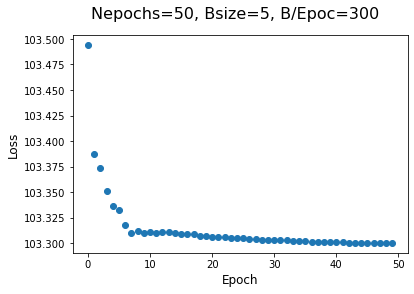

In [56]:
epochArr=range(0,total_epochs);
lossArr = [];
for i in messages_over_time:
    lossArr.append(i.loss.iloc[0])
    

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,4));

fig.suptitle('Nepochs={}, Bsize={}, B/Epoc={}'.format(total_epochs,batch,batch_per_epoch), fontsize=16)

ax1.plot(epochArr, lossArr, 'o', label='data');
# ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_ylim(27,28)
# ax1.legend()
# ax1.grid(True)
ax1.set_xlabel('Epoch', fontsize=12);
ax1.set_ylabel('Loss', fontsize=12);

fig.savefig('lossVSepoch_phi0.6_{}-{}-{}.png'.format(total_epochs,batch,batch_per_epoch))

In [16]:
a=2;
if a!=3 & a!=2:
    print("yes")

NotImplementedError: The current force function is for a spring. You will need to change the force function below to that expected by your simulation.

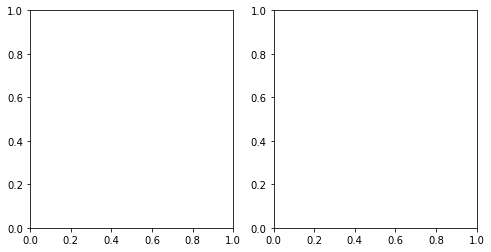

In [15]:

#Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    msgs = copy(messages_over_time[i])

    msgs['bd'] = msgs.r + 1e-2

    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        if sim == 'spring':
            force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        
        if sim == 'BD':
            force_fnc = lambda msg: (1/(msg.bd**12)[:, None] * np.array(msg[pos_cols]) 
            
        if sim != 'spring' | sim != 'BD':
            raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")

        
        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
    
from IPython.display import HTML
HTML(ani.to_jshtml())

NameError: name 'data' is not defined

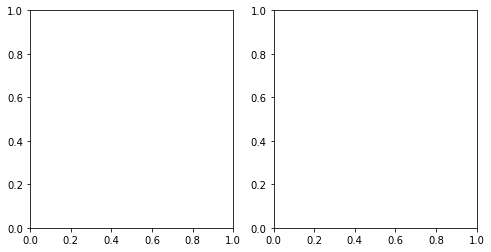

In [23]:
# For CPU

from simulate import make_transparent_color
from scipy.integrate import odeint

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
    i = 4 #Use this simulation
    if current_model > len(recorded_models):
        continue

    #Truth:
    cutoff_time = 300
    times = onp.array(s.times)[:cutoff_time]
    x_times = onp.array(data[i, :cutoff_time])
    masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = edge_index.cpu()
    ogn.cpu()
    if current_model > -1:
        ogn.load_state_dict(recorded_models[current_model])
    else:
        # Random model!
        ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()
    ogn.cpu()
    
    def odefunc(y, t=None):
        y = y.reshape(n, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cpu(),
            edge_index=e
        )
        dx = y[:, 2:4]
        dv = ogn.just_derivative(cur).cpu().detach().numpy()
        dother = np.zeros_like(dx)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, n, 6)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

        for k in range(2):
            ax[k].set_xlim(-1, 3)
            ax[k].set_ylim(-3, 1)
        plt.tight_layout()
        camera.snap()

# camera.animate().save('multiple_animations_with_comparison.mp4')
from IPython.display import HTML
HTML(camera.animate().to_jshtml())

In [ ]:
# # For GPU

# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# camera = Camera(fig)

# for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
#     i = 4 #Use this simulation
#     if current_model > len(recorded_models):
#         continue

#     #Truth:
#     cutoff_time = 300
#     times = onp.array(s.times)[:cutoff_time]
#     x_times = onp.array(data[i, :cutoff_time])
#     masses = x_times[:, :, -1]
#     length_of_tail = 75

#     #Learned:
#     e = edge_index.cuda()
#     ogn.cpu()
#     if current_model > -1:
#         ogn.load_state_dict(recorded_models[current_model])
#     else:
#         # Random model!
#         ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
#     ogn.cuda()
    
#     def odefunc(y, t=None):
#         y = y.reshape(n, 6).astype(np.float32)
#         cur = Data(
#             x=torch.from_numpy(y).cuda(),
#             edge_index=e
#         )
#         dx = y[:, 2:4]
#         dv = ogn.just_derivative(cur).cpu().detach().numpy()
#         dother = np.zeros_like(dx)
#         return np.concatenate((dx, dv, dother), axis=1).ravel()

#     datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, n, 6)
#     x_times2 = onp.array(datai)

#     d_idx = 10
#     for t_idx in range(d_idx, cutoff_time, d_idx):
#         start = max([0, t_idx-length_of_tail])
#         ctimes = times[start:t_idx]
#         cx_times = x_times[start:t_idx]
#         cx_times2 = x_times2[start:t_idx]
#         for j in range(n):
#             rgba = make_transparent_color(len(ctimes), j/n)
#             ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
#             ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
#             black_rgba = rgba
#             black_rgba[:, :3] = 0.75
#             ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

#         for k in range(2):
#             ax[k].set_xlim(-1, 3)
#             ax[k].set_ylim(-3, 1)
#         plt.tight_layout()
#         camera.snap()

# # camera.animate().save('multiple_animations_with_comparison.mp4')
# from IPython.display import HTML
# HTML(camera.animate().to_jshtml())

In [ ]:
#######################
# Symbolic regression #
#######################

In [ ]:
# Finally, one can install a free 30-day trial of Eureqa at this URL: https://www.nutonian.com/download/eureqa-desktop-download/.

# Extract the force laws with the following procedure:

#     The data in messages_over_time correspond to inputs to, and features of, ϕe, recorded during each training epoch.
#     Select the last element of this list.
#     Find the most significant message feature. Each message feature corresponds to 'e1', 'e2', etc. Calculate the one with the largest standard deviation.
#     Save that message to csv file along with the input features. Paste these into the data column of Eureqa (it's a GUI app).
#     Don't change anything on the "prepare data" tab.
#     Enable your choice of operators with complexity levels for each (this choice is up to you).
#     Set the loss to mean absolute error (the default) and begin training.
#     After you start training, you will be able to see a table of equations as a function of complexity and fit to the data. These represent a symbolic representation of the message function.
#     Find the equation that has the greatest drop in log mean absolute error over increase in complexity. This equation should be equal to a linear transform of the true force.

# Thus, we have extracted a force law from the graph network without priors on the functional form.

# This is the same technique we used to extract the unknown dark matter overdensity equation from the Quijote simulations

In [ ]:
# Here's the best message, which we will study:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])

In [ ]:
# Here's a pandas dataframe of the message data:
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

In [ ]:
# Now we just fit e4 as a function of dx, dy, r, m1, and m2, inside Eureqa.